In [1]:
!pip install graphviz
!pip install sklearn-pandas
!pip install isoweek
!pip install pandas_summary

In [2]:

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from fastai_custom.imports import *
from fastai_custom.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn.metrics import accuracy_score

from sklearn import metrics
set_plot_sizes(12,14,16)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
!gsutil cp -r gs://sk-kfp-kubeflowpipelines-eu/data/ .

Copying gs://sk-kfp-kubeflowpipelines-eu/data/training/dataset.csv...
Copying gs://sk-kfp-kubeflowpipelines-eu/data/validation/dataset.csv...         
/ [2 files][  2.6 MiB/  2.6 MiB]                                                
Operation completed over 2 objects/2.6 MiB.                                      


In [5]:
pwd

'/home/mlops-gcp/fastai'

In [15]:
import os
PATH=os.path.join(os.getcwd(),'data')

In [16]:
!ls {PATH}

training  validation


In [17]:
df_raw = pd.read_csv(f'{PATH}/training/dataset.csv', low_memory=False)

In [18]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [19]:
display_all(df_raw.tail().T)

,40004,40005,40006,40007,40008
Elevation,3394,3252,3384,3450,3217
Aspect,227,211,210,224,230
Slope,23,21,17,22,18
Horizontal_Distance_To_Hydrology,785,95,604,134,228
Vertical_Distance_To_Hydrology,-72,17,216,63,2
Horizontal_Distance_To_Roadways,3398,2333,579,3194,1048
Hillshade_9am,180,198,205,186,189
Hillshade_Noon,254,254,254,254,254
Hillshade_3pm,202,184,180,198,197
Horizontal_Distance_To_Fire_Points,2654,636,912,1710,1290


In [20]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Elevation,40009,NaN,NaN,NaN,2959.17,280.705,1880,2810,2996,3164,3857
Aspect,40009,NaN,NaN,NaN,155.219,111.978,0,58,126,261,360
Slope,40009,NaN,NaN,NaN,14.0614,7.44699,0,9,13,18,50
Horizontal_Distance_To_Hydrology,40009,NaN,NaN,NaN,268.005,211.392,0,108,218,384,1397
Vertical_Distance_To_Hydrology,40009,NaN,NaN,NaN,46.1304,57.8183,-157,7,29,68,601
Horizontal_Distance_To_Roadways,40009,NaN,NaN,NaN,2352.9,1560.95,0,1106,1995,3337,7069
Hillshade_9am,40009,NaN,NaN,NaN,212.221,26.6939,0,198,218,231,254
Hillshade_Noon,40009,NaN,NaN,NaN,223.265,19.7089,85,213,226,237,254
Hillshade_3pm,40009,NaN,NaN,NaN,142.424,38.0429,0,119,143,168,253
Horizontal_Distance_To_Fire_Points,40009,NaN,NaN,NaN,1976.88,1328.21,0,1024,1708,2539,7089


In [22]:
#m = RandomForestClassifier(n_jobs=-1)
#m.fit(df_raw.drop('Cover_Type', axis=1), df_raw.Cover_Type)

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call train_cats to convert strings to pandas categories.

In [23]:
train_cats(df_raw)

In [24]:
df_raw.Wilderness_Area.cat.categories

Index(['Cache', 'Commanche', 'Neota', 'Rawah'], dtype='object')

In [25]:
df_raw.Wilderness_Area.cat.codes

0        3
1        1
2        3
3        0
4        3
        ..
40004    3
40005    1
40006    3
40007    3
40008    2
Length: 40009, dtype: int8

In [26]:

display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Aspect                                0.0
Cover_Type                            0.0
Elevation                             0.0
Hillshade_3pm                         0.0
Hillshade_9am                         0.0
Hillshade_Noon                        0.0
Horizontal_Distance_To_Fire_Points    0.0
Horizontal_Distance_To_Hydrology      0.0
Horizontal_Distance_To_Roadways       0.0
Slope                                 0.0
Soil_Type                             0.0
Vertical_Distance_To_Hydrology        0.0
Wilderness_Area                       0.0
dtype: float64

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [27]:
len(df_raw)

40009

In [28]:
df_valid = pd.read_csv(f'{PATH}/validation/dataset.csv', low_memory=False)

In [29]:
len(df_valid)

9836

In [30]:
df_raw = pd.concat([df_raw,df_valid], axis=0, ignore_index=True)

In [31]:
len(df_raw)

49845

In [32]:
df, y, nas = proc_df(df_raw, 'Cover_Type')

In [33]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 9836  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((40009, 12), (40009,), (9836, 12))

In [34]:
def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [35]:
m = RandomForestClassifier(oob_score=True, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 15.5 s, sys: 176 ms, total: 15.7 s
Wall time: 8.68 s
[1.0, 0.8743391622610818, 0.8739033717413582]


In [36]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([1., 1., 1., 1., 4., 1., 4., 1., 1., 1., 4., 1., 0., 1., 1., 1., 1., 4., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 4., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 0., 5., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 4., 4., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 5.]),
 1.07,
 1)

In [37]:
preds.shape

(100, 9836)

In [38]:
int(round(np.mean(preds[:,0])))==y_valid[0]

True

In [39]:
[np.rint(np.mean(preds[:i+1], axis=0)) for i in range(3)]

[array([1., 1., 0., ..., 2., 0., 1.]),
 array([1., 1., 0., ..., 2., 2., 1.]),
 array([1., 1., 0., ..., 2., 1., 1.])]

In [40]:
a = np.array([1.1,2.6,3.3,4.9])
np.rint(a)

array([1., 3., 3., 5.])

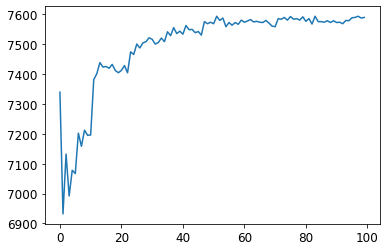

In [41]:
plt.plot([metrics.accuracy_score(y_valid, np.rint(np.mean(preds[:i+1], axis=0)),normalize=False) for i in range(100)]);

In [42]:
m.predict(X_valid).shape

(9836,)

In [43]:
res =y_valid == m.predict(X_valid)

In [44]:
np.count_nonzero(res)

8600

In [45]:
m = RandomForestClassifier(n_estimators=20, n_jobs=-1,oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[0.9987252868104677, 0.862545750305002, 0.8407358344372516]


In [46]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1,oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9997000674848159, 0.8706791378609191, 0.8599565097852984]


In [47]:
m = RandomForestClassifier(n_estimators=65, n_jobs=-1,oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9999750056237346, 0.8747458316388776, 0.8695043615186583]


In [ ]:
m = RandomForestClassifier(n_estimators=100, n_jobs=-1,oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [ ]:
t=m.estimators_[0].tree_
dectree_max_depth(t)

In [ ]:
m = RandomForestClassifier(n_estimators=200, n_jobs=-1,oob_score=True,min_samples_leaf=1,max_features='sqrt')
m.fit(X_train, y_train)
print_score(m)

In [ ]:
t=m.estimators_[0].tree_
dectree_max_depth(t)

In [ ]:
feat_imp = m.feature_importances_

In [ ]:
features = X_valid.columns.values

In [ ]:
feat_imp_list = [(item[0],round(item[1]*100,2)) for item in list(zip(features, feat_imp))]

In [ ]:
feat_imp_list

In [ ]:
feat_imp_list.sort(key=lambda x: x[1], reverse=True)

In [ ]:
feat_imp_list